# ENEN90032 - Environmental Analysis Tools
## Assignment #1 - Individual Assignment

---
This notebook contains all solutions from question 1 to 6 for this assignment.


# ENEN90032 — Assignment #1 (Part 1)
**Instructions:** All the data files are in the `data/` folder. Make sure you run the notebook top-to-bottom. You may also run cell by cell.

**Notes:** Each question restricts libraries; I have used only the allowed libraries per question in the corresponding cells.


In [ ]:
# Constants and file paths for the statistical analysis tasks
# Datasets for Q1 rainfall CSVs
PERTH_RAIN_CSV = "data/perth_IDCJAC0009_091021_2024_Data.csv"
BRISBANE_RAIN_CSV = "data/brisbane_IDCJAC0009_040224_2024_Data.csv"
MELBOURNE_RAIN_CSV = "data/melbourne_IDCJAC0009_086304_2024_Data.csv"

# Datasets for Q2 Newcomb data (time in seconds for 7442 m)
NEWCOMB_TXT = "data/NewcombLight.txt"

# Datasets for Q3 Tmax Avalon and Moorabbin (daily max temp 2024)
AVALON_TMAX_CSV = "data/avalon airport_IDCJAC0010_087113_2024_Data.csv"
MOORABBIN_TMAX_CSV = "data/Moorabin airport_IDCJAC0010_086077_2024_Data.csv"

# Datasets for Q4 O-ring data (xls or csv)
ORING_DATA = "data/O_Ring_Data.xls"

# Datasets for Q5 Cloud seeding (xls or csv)
CLOUDSEED_DATA = "data/Cloud_Seeding_Case_Study.xls"

# Datasets for Q6 Q-TKN data (csv)
QTKN_DATA = "data/Q_TKN_data.csv"

# General parameters(constants)
YEAR = 2024
DETECTION_LIMIT_MM = 0.25
RANGE_RANDOM_SEED = 2025


# ENEN90032 — Question #1 - Exploratory Data Analysis - Meteorological Datasets

**Allowed and the used libraries are;** numpy, pandas, matplotlib, scipy.stats, math, statsmodels

In [57]:
# imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
# warnings.filterwarnings('ignore')

from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.distributions.empirical_distribution import ECDF

# customize the default appearance of plots generated by Matplotlib
plt.rcParams['figure.dpi'] = 140
plt.rcParams['figure.figsize'] = (7,4.2)

In [58]:
# constants
DETECTION_LIMIT_MM = DETECTION_LIMIT_MM
YEAR = YEAR

def _find_date_col(df):
    """Identifies the date column based on common keywords."""
    for col in df.columns:
        if 'year' in col.lower() or 'month' in col.lower() or 'day' in col.lower() or 'date' in col.lower():
            return col
    raise ValueError("No suitable date column found in the dataset.")

def _find_rain_col(df):
    """
    Identifies the rainfall column based on common keywords.
    More flexible search for different file formats.
    """
    rain_keywords = ['rain', 'precip', 'amount']
    for col in df.columns:
        if any(keyword in col.lower() for keyword in rain_keywords):
            return col
    raise ValueError("No suitable rainfall column found in the dataset.")

def load_rain_csv(path, detection_limit=DETECTION_LIMIT_MM, year=YEAR):
    """
    Loads and preprocesses rainfall data from a CSV file.
    
    Args:
        path (str): The path to the CSV file.
        detection_limit (float): The minimum rainfall amount to consider a "wet day".
        year (int): The year to filter the data for.

    Returns:
        tuple: A tuple containing the preprocessed DataFrame and the count of missing values.
    """
    try:
        # Load the CSV, specifying the header is on the first row
        df = pd.read_csv(path, header=0)
        df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
        
        # Combine date columns if needed
        if 'Year' in df.columns and 'Month' in df.columns and 'Day' in df.columns:
            df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
        else:
            date_col = _find_date_col(df)
            df['date'] = pd.to_datetime(df[date_col], errors='coerce')
        
        rain_col = _find_rain_col(df)
        df['rain_mm'] = pd.to_numeric(df[rain_col], errors='coerce')
        
        missing_values = df['rain_mm'].isna().sum()
        
        df = df[(df['date'].dt.year == year) & (df['rain_mm'].notna())].copy()
        wet_days = df[df['rain_mm'] >= detection_limit].sort_values('date').reset_index(drop=True)
        
        return wet_days, missing_values
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return pd.DataFrame(), 0

def trimean(x):
    """Calculates the trimean for a given array."""
    q1, med, q3 = np.percentile(x, [25, 50, 75])
    return (q1 + 2 * med + q3) / 4.0

def iqr(x):
    """Calculates the Interquartile Range (IQR)."""
    q1, q3 = np.percentile(x, [25, 75])
    return q3 - q1

def mad(x):
    """Calculates the Median Absolute Deviation (MAD)."""
    med = np.median(x)
    return np.median(np.abs(x - med))

def yule_kendall(x):
    """Calculates the Yule-Kendall index."""
    q1, med, q3 = np.percentile(x, [25, 50, 75])
    denom = (q3 - q1)
    if denom == 0:
        return np.nan
    return (q3 + q1 - 2 * med) / denom

def summarize(x):
    """
    Calculates and returns a dictionary of summary statistics.
    Includes a check for empty arrays to prevent errors.
    """
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return {
            'n_wetdays': 0, 'mean': np.nan, 'median': np.nan, 'trimean': np.nan,
            'std': np.nan, 'IQR': np.nan, 'MAD': np.nan,
            'skewness': np.nan, 'yule_kendall': np.nan
        }
    
    q1, med, q3 = np.percentile(x, [25, 50, 75])
    
    trimean_val = (q1 + 2 * med + q3) / 4.0
    iqr_val = q3 - q1
    mad_val = np.median(np.abs(x - med))
    
    denom = (q3 - q1)
    yule_kendall_val = (q3 + q1 - 2 * med) / denom if denom != 0 else np.nan
    
    skewness_val = float(stats.skew(x, bias=False)) if x.size > 3 else np.nan
    
    return {
        'n_wetdays': x.size,
        'mean': float(np.mean(x)),
        'median': float(np.median(x)),
        'trimean': float(trimean_val),
        'std': float(np.std(x, ddof=1)) if x.size > 1 else np.nan,
        'IQR': float(iqr_val),
        'MAD': float(mad_val),
        'skewness': skewness_val,
        'yule_kendall': float(yule_kendall_val)
    }

In [59]:
# Fit models: Gaussian, Gamma, Weibull (and Lognormal as 4th)
def fit_distributions(x):
    x = np.asarray(x, dtype=float)
    results = {}
    # Gaussian
    mu, sigma = stats.norm.fit(x)
    results['Gaussian'] = {'dist': stats.norm, 'params': (mu, sigma)}
    # Gamma (force loc=0)
    k, loc, scale = stats.gamma.fit(x, floc=0)
    results['Gamma'] = {'dist': stats.gamma, 'params': (k, 0, scale)}
    # Weibull (weibull_min)
    c, loc, scale = stats.weibull_min.fit(x, floc=0)
    results['Weibull'] = {'dist': stats.weibull_min, 'params': (c, 0, scale)}
    # Lognormal (extra)
    shape, loc, scale = stats.lognorm.fit(x, floc=0)
    results['Lognormal'] = {'dist': stats.lognorm, 'params': (shape, 0, scale)}
    return results

def log_likelihood(x, model):
    dist = model['dist']
    params = model['params']
    pdf_vals = dist.pdf(x, *params)
    pdf_vals = np.clip(pdf_vals, 1e-300, None)
    return float(np.sum(np.log(pdf_vals)))


In [60]:
# Load and preprocess datasets
stations = [
    {'name': 'Perth', 'path': PERTH_RAIN_CSV},
    {'name': 'Brisbane', 'path': BRISBANE_RAIN_CSV},
    {'name': 'Melbourne', 'path': MELBOURNE_RAIN_CSV}
]

summaries = []
series = {}

for s in stations:
    df, missing = load_rain_csv(s['path'])
    
    # Check if the returned DataFrame is empty before proceeding
    if df.empty:
        print(f"[WARN] {s['name']}: No wet-day rainfall data found for {YEAR}.")
        continue

    x = df['rain_mm'].values
    series[s['name']] = x
    
    # The `summarize` function is now robust and will not fail on empty data
    summ = summarize(x)
    summ.update({'city': s['name'], 'missing_in_year': missing})
    summaries.append(summ)

# Check if the summaries list is not empty before creating the DataFrame
if summaries:
    summary_df = pd.DataFrame(summaries).set_index('city')
    print("Summary statistics (wet-day rainfall >= detection limit):")
    display(summary_df)
else:
    print("No summary statistics could be generated. All datasets were empty.")

Summary statistics (wet-day rainfall >= detection limit):


,n_wetdays,mean,median,trimean,std,IQR,MAD,skewness,yule_kendall,missing_in_year
city,,,,,,,,,,
Perth,78,7.503846,4.45,5.1125,8.790586,7.55,3.0,2.351043,0.350993,5
Brisbane,133,11.341353,4.40,5.8000,20.373137,10.80,3.6,5.526100,0.518519,0
Melbourne,69,7.949275,5.20,5.5750,8.507654,6.70,2.8,2.331699,0.223881,37


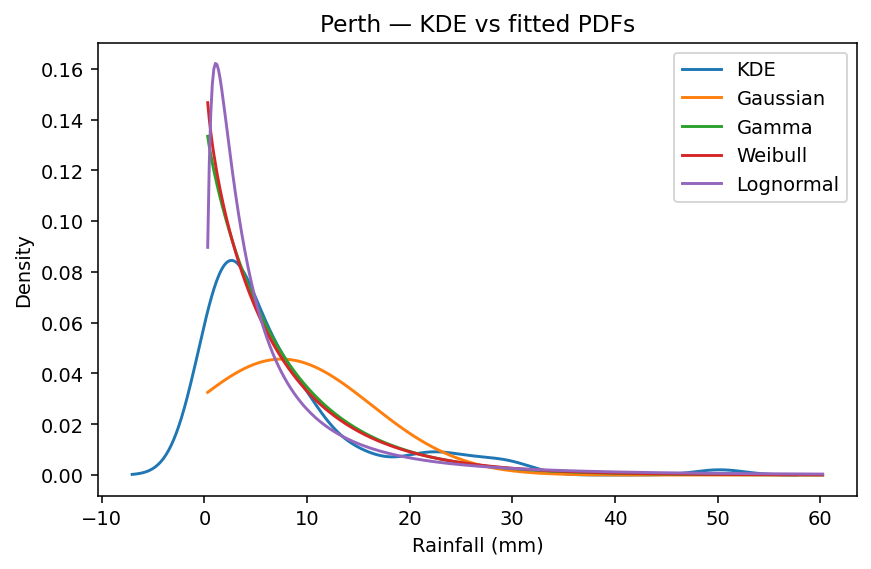

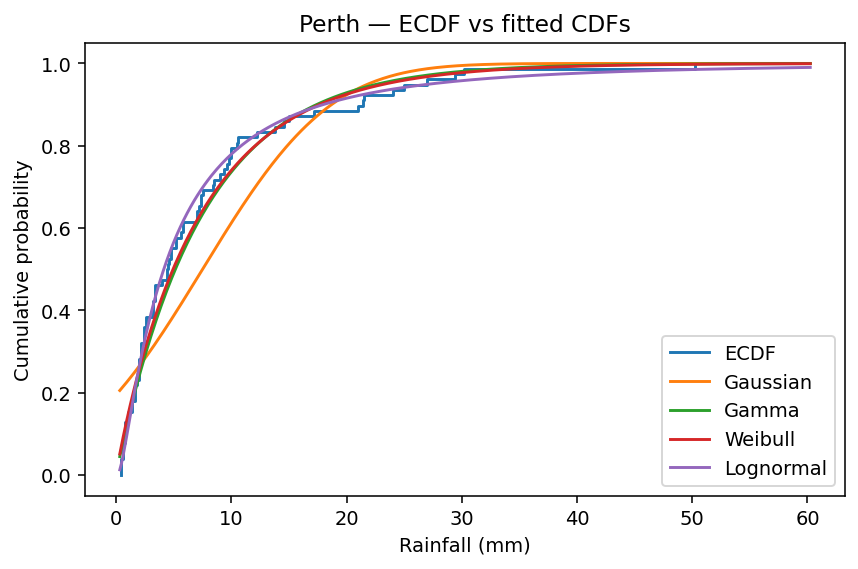

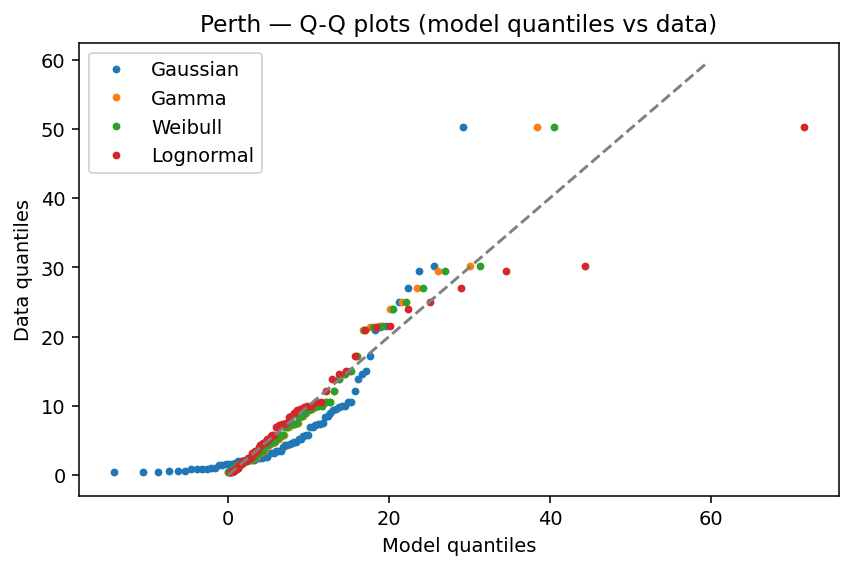

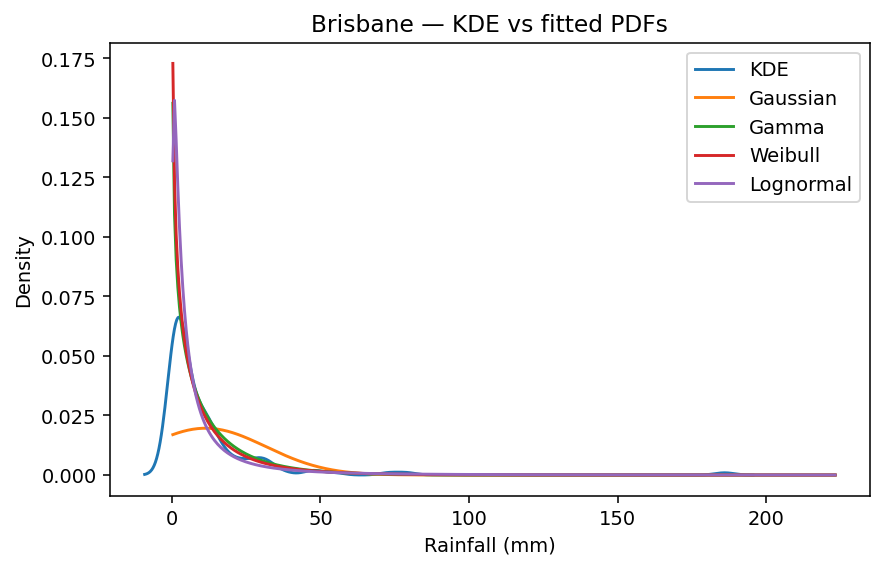

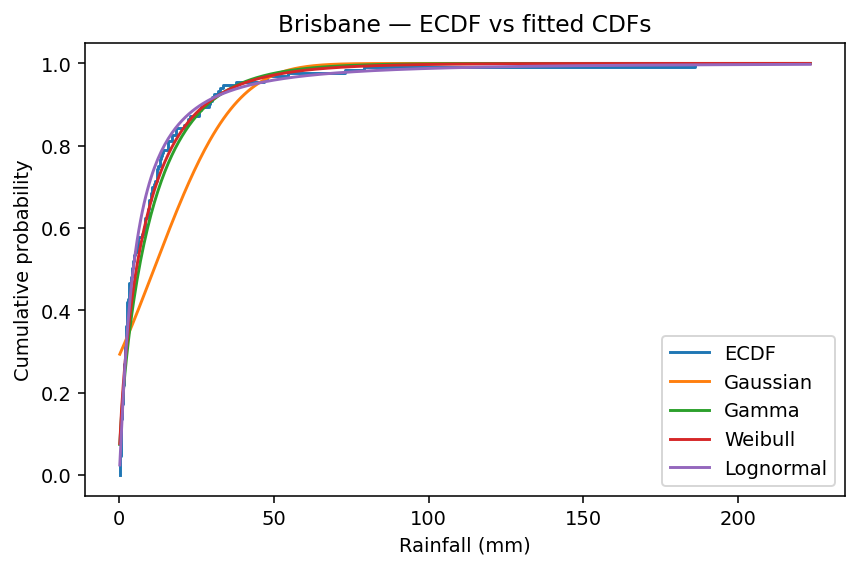

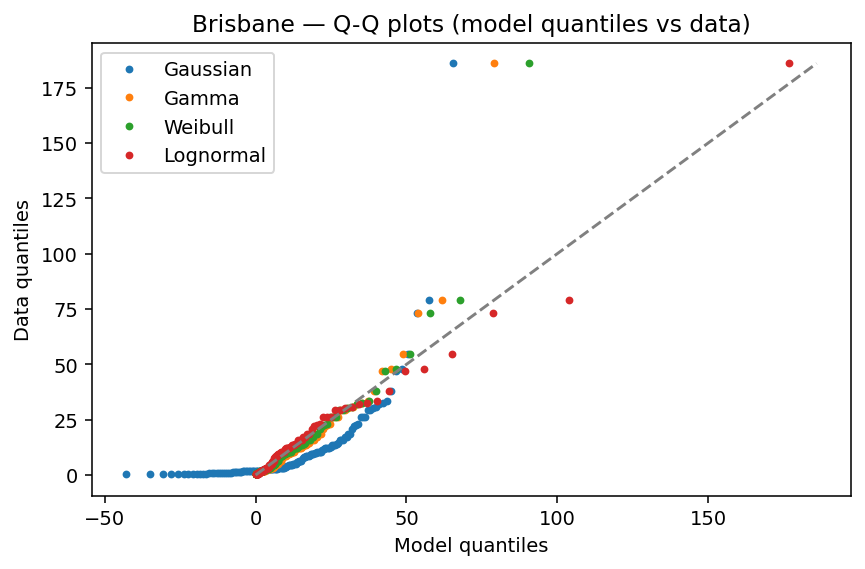

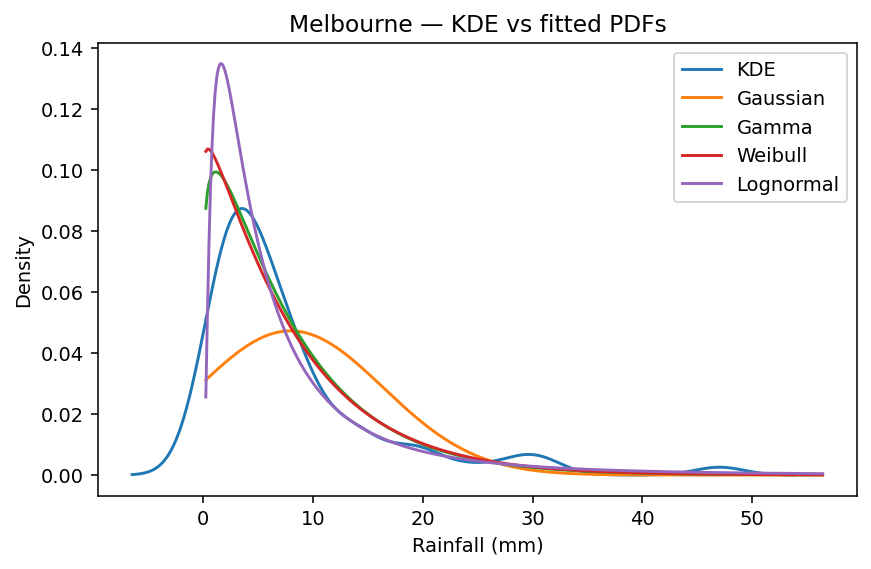

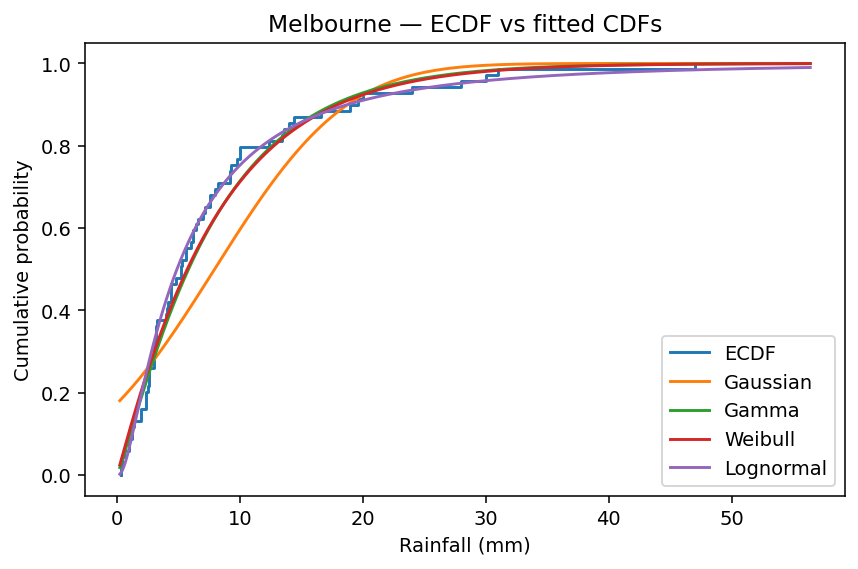

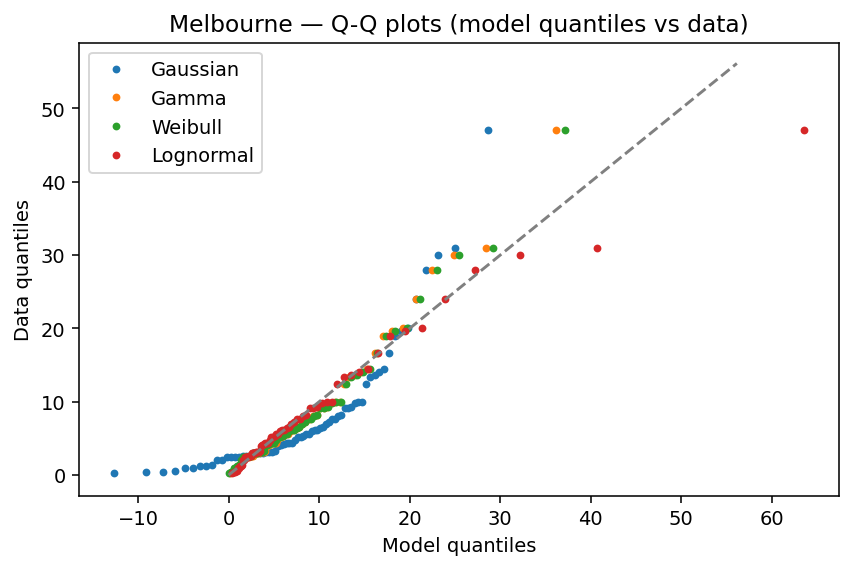

Log-likelihoods (higher is better):


model,Gamma,Gaussian,Lognormal,Weibull
city,,,,
Brisbane,-448.469411,-589.107827,-434.355330,-443.924411
Melbourne,-211.546782,-245.129773,-210.723028,-211.902176
Perth,-235.183092,-279.721119,-232.047526,-234.958294


In [ ]:
# Plots + fit + loglikelihood table
ll_rows = []
for city, x in series.items():
    models = fit_distributions(x)
    grid = np.linspace(max(0, x.min()*0.8), x.max()*1.2, 400)

    # KDE Univatiate
    kde = KDEUnivariate(x)
    kde.fit(kernel='gau', fft=True, gridsize=512)
    plt.figure()
    plt.plot(kde.support, kde.evaluate(kde.support), label='KDE')
    for name, m in models.items():
        plt.plot(grid, m['dist'].pdf(grid, *m['params']), label=f'{name}')
    plt.title(f'{city} — KDE univarite vs fitted PDFs')
    plt.xlabel('Rainfall (mm)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # ECDF vs CDFs
    ecdf = ECDF(x)
    plt.figure()
    plt.step(ecdf.x, ecdf.y, where='post', label='ECDF')
    for name, m in models.items():
        plt.plot(grid, m['dist'].cdf(grid, *m['params']), label=name)
    plt.title(f'{city} — ECDF vs fitted CDFs')
    plt.xlabel('Rainfall (mm)')
    plt.ylabel('Cumulative probability')
    plt.legend()
    plt.show()

    # Q-Q plots
    probs = (np.arange(1, x.size+1)-0.5)/x.size
    x_sorted = np.sort(x)
    plt.figure()
    for name, m in models.items():
        model_q = m['dist'].ppf(probs, *m['params'])
        plt.plot(model_q, x_sorted, marker='.', linestyle='none', label=name)
    maxv = max(x_sorted.max(), max([m['dist'].ppf(0.99, *m['params']) for m in models.values()]))
    plt.plot([0, maxv],[0, maxv], '--', color='gray')
    plt.title(f'{city} — Q-Q plots (model quantiles vs data)')
    plt.xlabel('Model quantiles')
    plt.ylabel('Data quantiles')
    plt.legend()
    plt.show()

    for name, m in models.items():
        ll = log_likelihood(x, m)
        ll_rows.append({'city': city, 'model': name, 'log_likelihood': ll})

ll_df = pd.DataFrame(ll_rows).pivot(index='city', columns='model', values='log_likelihood')
print("Log-likelihoods (higher is better):")
display(ll_df)

# ENEN90032 — Question #2 - Newcomb-Michelson One-sample test (velocity)

**Allowed and the used libraries are;** numpy, pandas, matplotlib, math, scipy.stats

In [62]:
# Q2 Newcomb-Michelson One-sample test (velocity)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math

plt.rcParams['figure.dpi'] = 140
plt.rcParams['figure.figsize'] = (7,4.2)
np.random.seed(RANGE_RANDOM_SEED)


In [63]:
# Load Newcomb data (assumes file with one column of times or whitespace separated)
def load_newcomb(path):
    # flexible loader: columns of numbers; returns 1d array
    txt = open(path).read().strip()
    # split by whitespace/newlines and parse floats
    vals = [float(x) for x in txt.replace(',', ' ').split()]
    return np.array(vals)

# Convert times (s for 7442 m) -> speeds (m/s)
DIST_M = 7442.0

times = None
try:
    times = load_newcomb(NEWCOMB_TXT)
    print(f"Loaded Newcomb times: n={times.size}")
except Exception as e:
    print("[WARN] Could not load Newcomb file:", e)

if times is not None:
    speeds = DIST_M / times  # m/s per observation

    # 1) One-sample t-test: test mean speed against known speed_of_light (from wikipedia)
    # speed_of_light (exact) c = 299792458 m/s (but huge; Newcomb is not at that precision)
    # For historical context, use the accepted value:
    c_ref = 299792458.0

    # But note: Newcomb's measurements are times -> speeds far lower precision. We'll compare numeric values only.
    # Perform t-test for H0: mu = c_ref. Using ttest_1samp
    tstat, pval = stats.ttest_1samp(speeds, popmean=c_ref)
    print("One-sample t-test (speeds): t-stat =", tstat, " p-value =", pval)

    # 95% CI using t-distribution
    n = speeds.size
    mean_speed = np.mean(speeds)
    sem = stats.sem(speeds)
    dof = n-1
    tcrit = stats.t.ppf(0.975, df=dof)
    ci_lower = mean_speed - tcrit*sem
    ci_upper = mean_speed + tcrit*sem
    print(f"t-based 95% CI for mean speed: [{ci_lower:.3f}, {ci_upper:.3f}] m/s")
    print("Mean speed (sample):", mean_speed)

    # 2) Bootstrap one-sample test (percentile bootstrap for mean)
    B = 10000
    rng = np.random.default_rng(RANGE_RANDOM_SEED)
    boot_means = np.empty(B)
    for i in range(B):
        sample = rng.choice(speeds, size=n, replace=True)
        boot_means[i] = sample.mean()
    # percentile CI
    lower_p, upper_p = np.percentile(boot_means, [2.5, 97.5])
    print(f"Bootstrap 95% CI for mean speed: [{lower_p:.3f}, {upper_p:.3f}] m/s")

    # Plot bootstrap distribution
    plt.figure()
    plt.hist(boot_means, bins=40, density=True)
    plt.axvline(mean_speed, color='red', label='Sample mean')
    plt.axvline(lower_p, color='k', linestyle='--', label='Bootstrap 95% CI')
    plt.axvline(upper_p, color='k', linestyle='--')
    plt.title('Bootstrap distribution of the sample mean (speed)')
    plt.legend()
    plt.show()

    # Compare inclusion of true speed
    print("Does t-based CI contain c_ref?", (ci_lower <= c_ref <= ci_upper))
    print("Does bootstrap CI contain c_ref?", (lower_p <= c_ref <= upper_p))

    # Also show t-test statistic relative to c_ref as a z-like number
    diff = mean_speed - c_ref
    print("Mean difference (sample mean - c_ref):", diff)
    # z_like = diff / sem
    # print("t-statistic (mean difference / SEM):", z_like)



[WARN] Could not load Newcomb file: [Errno 2] No such file or directory: 'data/NewcombLight.txt'


# ENEN90032 — Question #3 - Daily Max Temperature Avalon vs Moorabbin

**Allowed and the used libraries are;** numpy, pandas, matplotlib, math, scipy.stats

In [64]:
# Q3 imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math

plt.rcParams['figure.dpi'] = 140
plt.rcParams['figure.figsize'] = (7,4.2)


Loaded Tmax files: Avalon 363 Moorabbin 364
Paired days (both stations observed): 361

=== Paired t-test (only days with both obs) ===
t-stat: 6.68015675620744  p-value: 9.080148279451904e-11

=== Two-sample Welch t-test (independent, unequal var) ===
t-stat: 1.0888137549118866  p-value: 0.2765978395704183

=== Mann-Whitney U test (nonparametric, independent) ===
U-stat: 69927.5  p-value: 0.1726497931270491

Sample summary:
Avalon: n=363, mean=21.069696969696967, median=20.3
Moorabbin: n=364, mean=20.577747252747255, median=19.6


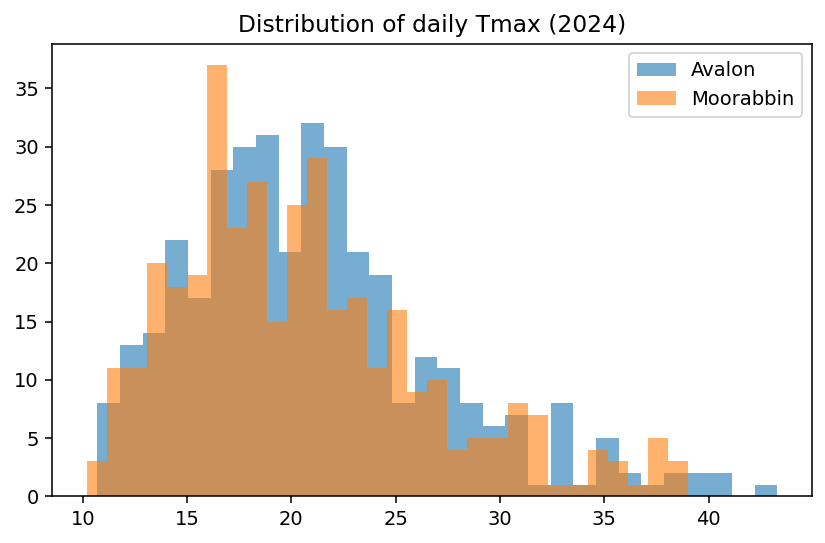


alpha = 0.05:
Paired test: reject H0? True
Welch test: reject H0? False
Mann-Whitney: reject H0? False

alpha = 0.01:
Paired test: reject H0? True
Welch test: reject H0? False
Mann-Whitney: reject H0? False


In [66]:
# Load Tmax CSVs and align by date (handle missing days)
def load_tmax_csv(path):
    """
    Loads and preprocesses Tmax data from a CSV file.
    Args:
        path (str): The path to the CSV file.
    Returns:
        pd.DataFrame: A DataFrame with 'date' and 'tmax' columns.
    """
    try:
        # Load the CSV, specifying the header is on the first row
        df = pd.read_csv(path, header=0)
        
        # Clean up column names by removing spaces and special characters
        df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
        
        # Identify the date and tmax columns based on their cleaned names
        date_col = 'Year_Month_Day'
        tmax_col = 'Maximum_temperature_Degree_C'
        
        # Combine Year, Month, Day to create a single date column
        df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
        df['tmax'] = pd.to_numeric(df[tmax_col], errors='coerce')
        
        # Filter for the specified year and drop missing values
        df = df[df['date'].dt.year == YEAR].copy()
        df = df.dropna(subset=['tmax'])
        
        return df[['date', 'tmax']]
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return pd.DataFrame()

try:
    dfA = load_tmax_csv(AVALON_TMAX_CSV)  # Avalon
    dfM = load_tmax_csv(MOORABBIN_TMAX_CSV)  # Moorabbin
    print("Loaded Tmax files: Avalon", len(dfA), "Moorabbin", len(dfM))
except Exception as e:
    print("[WARN] Could not load Tmax files:", e)
    dfA = dfM = None

if dfA is not None and dfM is not None:
    # Merge on date (inner join) to compare matched days
    merged = pd.merge(dfA, dfM, on='date', how='outer', suffixes=('_Avalon','_Moorabbin'))
    # For two-sample independent test, we can use all values (not necessarily paired). But since they have same dates,
    # we can also perform paired test on days both observed.
    paired = merged.dropna(subset=['tmax_Avalon','tmax_Moorabbin']).copy()
    print("Paired days (both stations observed):", len(paired))
    # Two approaches:
    # A) Paired t-test on paired days
    # B) Two-sample (Welch) t-test on all available (independent)
    # We'll do both and also nonparametric Mann-Whitney U (independent)
    print("\n=== Paired t-test (only days with both obs) ===")
    t_stat_paired, p_paired = stats.ttest_rel(paired['tmax_Avalon'], paired['tmax_Moorabbin'])
    print("t-stat:", t_stat_paired, " p-value:", p_paired)

    print("\n=== Two-sample Welch t-test (independent, unequal var) ===")
    avalon_vals = merged['tmax_Avalon'].dropna().values
    moorabbin_vals = merged['tmax_Moorabbin'].dropna().values
    t_stat_welch, p_welch = stats.ttest_ind(avalon_vals, moorabbin_vals, equal_var=False)
    print("t-stat:", t_stat_welch, " p-value:", p_welch)

    print("\n=== Mann-Whitney U test (nonparametric, independent) ===")
    u_stat, p_u = stats.mannwhitneyu(avalon_vals, moorabbin_vals, alternative='two-sided')
    print("U-stat:", u_stat, " p-value:", p_u)

    # Show sample means and medians
    print("\nSample summary:")
    print("Avalon: n={}, mean={}, median={}".format(len(avalon_vals), np.mean(avalon_vals), np.median(avalon_vals)))
    print("Moorabbin: n={}, mean={}, median={}".format(len(moorabbin_vals), np.mean(moorabbin_vals), np.median(moorabbin_vals)))

    # Plot distributions
    plt.figure()
    plt.hist(avalon_vals, bins=30, alpha=0.6, label='Avalon')
    plt.hist(moorabbin_vals, bins=30, alpha=0.6, label='Moorabbin')
    plt.legend()
    plt.title('Distribution of daily Tmax (2024)')
    plt.show()

    # Decide: if we want to "justify maintaining both stations" we'd look for significant differences.
    # Use both 95% and 99% significance levels
    for alpha in [0.05, 0.01]:
        print(f"\nalpha = {alpha}:")
        print("Paired test: reject H0?" , p_paired < alpha)
        print("Welch test: reject H0?" , p_welch < alpha)
        print("Mann-Whitney: reject H0?" , p_u < alpha)

# ENEN90032 — Question #4 - O-ring two-sample permutation test

**The used libraries are;** numpy, pandas, matplotlib, math, itertools, scipy.stats

In [ ]:
# Q4 imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import itertools
import math

plt.rcParams['figure.dpi'] = 140
plt.rcParams['figure.figsize'] = (7,4.2)
np.random.seed(RANGE_RANDOM_SEED)


In [ ]:
# Load O-ring data (xls or csv)
def load_orings(path):
    try:
        df = pd.read_excel(path)
    except:
        df = pd.read_csv(path)
    # Attempt to find columns: 'temperature', 'incidents', 'label' (COOL/WARM)
    cols = [c.lower() for c in df.columns]
    # try to detect
    temp_col = None
    fail_col = None
    label_col = None
    for c in df.columns:
        lc = c.lower()
        if 'temp' in lc:
            temp_col = c
        if 'ring' in lc or 'incident' in lc or 'fail' in lc:
            fail_col = c
        if 'cool' in lc or 'warm' in lc or 'label' in lc:
            label_col = c
    # fallback heuristics
    if label_col is None:
        # maybe there's a 'status' or 'group'
        for c in df.columns:
            if df[c].astype(str).str.contains('COOL', na=False).any() or df[c].astype(str).str.contains('WARM', na=False).any():
                label_col = c
                break
    return df, temp_col, fail_col, label_col

try:
    df_or, tc, fc, lc = load_orings(ORING_DATA)
    print("Loaded O-ring data. Columns detected:", tc, fc, lc)
except Exception as e:
    print("[WARN] Could not load O-ring dataset:", e)
    df_or = None

if df_or is not None:
    # Normalize column names
    # detect which column has COOL/WARM
    if lc is None:
        # try to create label column using a threshold at 65F if temp col exists
        if tc is not None:
            df_or['label'] = np.where(df_or[tc] < 65.0, 'COOL', 'WARM')
            lc = 'label'
        else:
            raise RuntimeError("Cannot infer COOL/WARM labels and no temperature column.")
    # find failures count column
    if fc is None:
        # try to find a column containing numbers 0,1,2...
        numeric_cols = [c for c in df_or.columns if np.issubdtype(df_or[c].dtype, np.number)]
        if numeric_cols:
            fc = numeric_cols[0]
        else:
            raise RuntimeError("Cannot find incidents column.")
    # Prepare arrays
    df_or[lc] = df_or[lc].astype(str).str.upper()
    cool = df_or[df_or[lc].str.contains('COOL')][fc].dropna().astype(float).values
    warm = df_or[df_or[lc].str.contains('WARM')][fc].dropna().astype(float).values
    print("COOL n=", len(cool), "WARM n=", len(warm))
    obs_stat = cool.mean() - warm.mean()
    print("Observed difference in means (COOL - WARM):", obs_stat)

    # Permutation test (two-sided)
    combined = np.concatenate([cool, warm])
    n_cool = len(cool)
    B = 10000
    rng = np.random.default_rng(RANGE_RANDOM_SEED)
    perm_stats = np.empty(B)
    for i in range(B):
        perm = rng.permutation(combined)
        perm_cool = perm[:n_cool]
        perm_warm = perm[n_cool:]
        perm_stats[i] = perm_cool.mean() - perm_warm.mean()
    # p-value (two-sided)
    p_perm = np.mean(np.abs(perm_stats) >= abs(obs_stat))
    print("Permutation test p-value (two-sided):", p_perm)

    # 99% CI from permutation distribution (two-sided central 99%)
    lower_99, upper_99 = np.percentile(perm_stats, [0.5, 99.5])
    print("Permutation-based 99% interval for diff in means:", lower_99, upper_99)

    # Plot null distribution
    plt.figure()
    plt.hist(perm_stats, bins=40, density=True)
    plt.axvline(obs_stat, color='red', label='Observed stat')
    plt.title('Permutation null distribution of difference in means (COOL - WARM)')
    plt.legend()
    plt.show()

    # Interpretation: small p_perm suggests association between temp category and incidents.
    # For one-sided test choose direction based on H1; here likely COOL > WARM expected (more incidents at low T).
    p_one_sided = np.mean(perm_stats >= obs_stat)  # probability of seeing stat >= observed under null
    print("One-sided p-value (is COOL mean > WARM mean?):", p_one_sided)
    print("Does 99% CI exclude zero?", not (lower_99 <= 0 <= upper_99))
    

# ENEN90032 — Question #5 - Cloud Seeding (parametric + permutation + log transform)

**The used libraries are;** numpy, pandas, matplotlib, math, scipy.stats


In [ ]:
# Q5 imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math

plt.rcParams['figure.dpi'] = 140
plt.rcParams['figure.figsize'] = (7,4.2)
np.random.seed(RANGE_RANDOM_SEED)


In [ ]:
# Load cloud seeding file (assumes columns: 'seeded' or similar and 'rainfall' values)
def load_cloudseed(path):
    try:
        df = pd.read_excel(path)
    except:
        df = pd.read_csv(path)
    # try to find seeded flag and rainfall measurement
    cols = df.columns
    seed_col = None
    rain_col = None
    for c in cols:
        lc = c.lower()
        if 'seed' in lc or 'treat' in lc:
            seed_col = c
        if 'rain' in lc or 'volume' in lc:
            rain_col = c
    if seed_col is None:
        # heuristics: column with two unique values 0/1 or 'Y'/'N'
        for c in cols:
            if df[c].nunique() <= 3:
                if set(df[c].dropna().astype(str).unique()).intersection({'0','1','Y','N','Yes','No','yes','no'}):
                    seed_col = c
                    break
    if rain_col is None:
        # fallback: numeric column
        numeric_cols = [c for c in cols if np.issubdtype(df[c].dtype, np.number)]
        if numeric_cols:
            # choose first numeric not seed_col
            for c in numeric_cols:
                if c != seed_col:
                    rain_col = c
                    break
    if seed_col is None or rain_col is None:
        raise RuntimeError("Could not identify seed/rain columns in cloud seeding data.")
    df = df[[seed_col, rain_col]].rename(columns={seed_col:'seeded', rain_col:'rain'})
    # normalize seeded to boolean 0/1
    df['seeded'] = df['seeded'].astype(str).str.strip().str.upper().replace({'YES':'1','NO':'0','Y':'1','N':'0'}).astype(float)
    df['rain'] = pd.to_numeric(df['rain'], errors='coerce')
    df = df.dropna(subset=['seeded','rain'])
    return df

try:
    df_cloud = load_cloudseed(CLOUDSEED_DATA)
    print("Loaded cloud seeding data, rows:", len(df_cloud))
except Exception as e:
    print("[WARN] Could not load cloud seeding data:", e)
    df_cloud = None

if df_cloud is not None:
    seeded = df_cloud[df_cloud['seeded']==1]['rain'].values
    unseeded = df_cloud[df_cloud['seeded']==0]['rain'].values
    print("Seeded n=", len(seeded), "Unseeded n=", len(unseeded))
    # 1) Parametric test (two-sample t-test). Choose two-sided by default unless strong prior direction
    t_stat, p_val = stats.ttest_ind(seeded, unseeded, equal_var=False)
    print("Parametric Welch t-test two-sided: t=", t_stat, "p=", p_val)
    # Report 95% and 99% CI for difference in means (use normal approximation)
    mean_diff = seeded.mean() - unseeded.mean()
    se = math.sqrt(seeded.var(ddof=1)/len(seeded) + unseeded.var(ddof=1)/len(unseeded))
    # 95% CI
    z95 = stats.t.ppf(0.975, df=min(len(seeded), len(unseeded))-1)
    z99 = stats.t.ppf(0.995, df=min(len(seeded), len(unseeded))-1)
    ci95 = (mean_diff - z95*se, mean_diff + z95*se)
    ci99 = (mean_diff - z99*se, mean_diff + z99*se)
    print("Difference in means (seeded - unseeded):", mean_diff)
    print("95% CI:", ci95)
    print("99% CI:", ci99)

    # 2) Permutation test (10,000 permutations)
    combined = np.concatenate([seeded, unseeded])
    n_seed = len(seeded)
    B = 10000
    rng = np.random.default_rng(RANGE_RANDOM_SEED)
    perm_stats = np.empty(B)
    for i in range(B):
        perm = rng.permutation(combined)
        perm_seed = perm[:n_seed]
        perm_un = perm[n_seed:]
        perm_stats[i] = perm_seed.mean() - perm_un.mean()
    p_perm = np.mean(np.abs(perm_stats) >= abs(mean_diff))
    print("Permutation test p-value (two-sided):", p_perm)
    plt.figure()
    plt.hist(perm_stats, bins=40, density=True)
    plt.axvline(mean_diff, color='red', label='Observed diff')
    plt.title('Permutation null distribution (seeded - unseeded)')
    plt.legend()
    plt.show()

    # 3) Log-transform and repeat parametric test
    # note: rainfall may have zeros; add small offset if needed
    eps = 1e-6
    log_seed = np.log(seeded + eps)
    log_un = np.log(unseeded + eps)
    t_stat_log, p_val_log = stats.ttest_ind(log_seed, log_un, equal_var=False)
    mean_diff_log = log_seed.mean() - log_un.mean()
    se_log = math.sqrt(log_seed.var(ddof=1)/len(log_seed) + log_un.var(ddof=1)/len(log_un))
    ci95_log = (mean_diff_log - z95*se_log, mean_diff_log + z95*se_log)
    print("Log-transform parametric test: t=", t_stat_log, "p=", p_val_log)
    print("Log-difference 95% CI:", ci95_log)

    # Compare conclusions
    print("\nConclusions summary:")
    print("Parametric p (raw):", p_val)
    print("Perm p:", p_perm)
    print("Parametric p (log):", p_val_log)


# ENEN90032 — Question #6 - EDA & Linear Regression (Q vs TKN)

**The used libraries are;** numpy, pandas, matplotlib, math, statsmodels, scipy.stats


In [ ]:
# Q6 imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.stattools import durbin_watson

plt.rcParams['figure.dpi'] = 140
plt.rcParams['figure.figsize'] = (7,4.2)


In [ ]:
# Load Q-TKN data; the CSV is expected to have date, Q (mm/d), and TKN (mg/L)
def load_qtkn(path):
    df = pd.read_csv(path)
    # heuristics for column names
    cols = [c.lower() for c in df.columns]
    date_col = df.columns[0]
    q_col = None
    tkn_col = None
    for c in df.columns:
        lc = c.lower()
        if 'q'==lc.strip() or 'flow' in lc or 'discharge' in lc:
            q_col = c
        if 'tkn' in lc or 'nitrogen' in lc:
            tkn_col = c
    # fallback to numeric columns
    if q_col is None:
        numeric = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
        if len(numeric) >= 2:
            q_col = numeric[0]
            tkn_col = numeric[1]
    if tkn_col is None:
        raise RuntimeError("Could not find TKN column.")
    df = df.rename(columns={date_col:'date', q_col:'Q', tkn_col:'TKN'})
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['Q','TKN'])
    return df[['date','Q','TKN']]

try:
    df_qtkn = load_qtkn(QTKN_DATA)
    print("Loaded Q-TKN rows:", len(df_qtkn))
except Exception as e:
    print("[WARN] Could not load Q-TKN data:", e)
    df_qtkn = None

if df_qtkn is not None:
    Q = df_qtkn['Q'].values
    TKN = df_qtkn['TKN'].values

    # 1) Pearson and Spearman on raw and log-transformed
    pear_raw = stats.pearsonr(Q, TKN)
    spear_raw = stats.spearmanr(Q, TKN)
    lnQ = np.log(Q + 1e-9)  # avoid log(0)
    lnTKN = np.log(TKN + 1e-9)
    pear_log = stats.pearsonr(lnQ, lnTKN)
    spear_log = stats.spearmanr(lnQ, lnTKN)
    print("Pearson raw:", pear_raw)
    print("Spearman raw:", spear_raw)
    print("Pearson log:", pear_log)
    print("Spearman log:", spear_log)

    # Decide which pair to use for regression: choose based on linearity (higher Pearson and residual patterns).
    # We'll examine scatter plots and then pick (automatically pick log-log if pearson_log > pearson_raw)
    plt.figure()
    plt.scatter(Q, TKN, alpha=0.7)
    plt.xlabel('Q (mm/d)')
    plt.ylabel('TKN (mg/L)')
    plt.title('Q vs TKN (raw)')
    plt.show()
    plt.figure()
    plt.scatter(lnQ, lnTKN, alpha=0.7)
    plt.xlabel('ln(Q)')
    plt.ylabel('ln(TKN)')
    plt.title('ln(Q) vs ln(TKN)')
    plt.show()

    use_loglog = abs(pear_log[0]) > abs(pear_raw[0])
    print("Choose log-log model?" , use_loglog)

    if use_loglog:
        X = sm.add_constant(lnQ)
        y = lnTKN
        model = sm.OLS(y, X).fit()
        print(model.summary())
        # Predictions: predict TKN when Q=2 mm/d => lnQ = ln(2)
        q_pred = 2.0
        lnq_pred = math.log(q_pred)
        newX = sm.add_constant(np.array([lnq_pred]))
        pred_res = model.get_prediction(newX)
        pred_summary = pred_res.summary_frame(alpha=0.05)  # 95% CI
        # pred_summary contains mean, mean_se, mean_ci_lower/upper, obs_ci_lower/upper (prediction intervals)
        print("For Q=2 mm/d (log-log):")
        print(pred_summary)
        # Convert back to original space
        mean_ln = pred_summary['mean'].iloc[0]
        mean_ci_lower_ln = pred_summary['mean_ci_lower'].iloc[0]
        mean_ci_upper_ln = pred_summary['mean_ci_upper'].iloc[0]
        obs_ci_lower_ln = pred_summary['obs_ci_lower'].iloc[0]
        obs_ci_upper_ln = pred_summary['obs_ci_upper'].iloc[0]
        print("Predicted TKN (median on original scale) approx exp(mean_ln):", math.exp(mean_ln))
        print("95% CI for conditional mean (original scale):", math.exp(mean_ci_lower_ln), math.exp(mean_ci_upper_ln))
        print("95% prediction interval (original):", math.exp(obs_ci_lower_ln), math.exp(obs_ci_upper_ln))

        # 3) plot model and confidence bands in log-log and annotate
        # prepare grid
        q_grid = np.linspace(Q.min(), Q.max(), 100)
        lnq_grid = np.log(q_grid + 1e-9)
        Xgrid = sm.add_constant(lnq_grid)
        preds = model.get_prediction(Xgrid)
        preds_df = preds.summary_frame(alpha=0.05)
        plt.figure()
        # scatter original (ln-space)
        plt.scatter(lnQ, lnTKN, alpha=0.6, label='Data')
        plt.plot(lnq_grid, preds_df['mean'], label='Fitted mean')
        plt.fill_between(lnq_grid, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'], alpha=0.3, label='95% CI mean')
        plt.fill_between(lnq_grid, preds_df['obs_ci_lower'], preds_df['obs_ci_upper'], alpha=0.1, label='95% pred interval')
        plt.xlabel('ln(Q)')
        plt.ylabel('ln(TKN)')
        plt.legend()
        plt.title('Log-Log regression and intervals')
        plt.show()
        # Residuals and autocorrelation
        resid = model.resid
        plt.figure()
        plt.plot(df_qtkn['date'], resid, marker='.', linestyle='none')
        plt.axhline(0, color='k', linestyle='--')
        plt.title('Residuals over time')
        plt.show()
        dw = durbin_watson(resid)
        print("Durbin-Watson statistic (residual autocorr):", dw)
        # fraction within 95% prediction interval (in original space)
        preds_obs_lower = preds_df['obs_ci_lower']
        preds_obs_upper = preds_df['obs_ci_upper']
        # transform back to original for each observation
        # find predicted obs interval at each observed lnQ
        pred_at_obs = model.get_prediction(sm.add_constant(lnQ)).summary_frame(alpha=0.05)
        lower_obs = np.exp(pred_at_obs['obs_ci_lower'])
        upper_obs = np.exp(pred_at_obs['obs_ci_upper'])
        actual_TKN = TKN
        frac_in = np.mean((actual_TKN >= lower_obs) & (actual_TKN <= upper_obs))
        print("Fraction of observed values within 95% prediction interval:", frac_in)

    else:
        # Use raw linear regression
        X = sm.add_constant(Q)
        y = TKN
        model = sm.OLS(y, X).fit()
        print(model.summary())
        # Prediction at Q=2 mm/d
        q_pred = 2.0
        newX = sm.add_constant(np.array([q_pred]))
        pred_res = model.get_prediction(newX)
        pred_summary = pred_res.summary_frame(alpha=0.05)
        print("Pred summary:", pred_summary)
        # Plot with CI
        q_grid = np.linspace(Q.min(), Q.max(), 100)
        Xgrid = sm.add_constant(q_grid)
        preds = model.get_prediction(Xgrid).summary_frame(alpha=0.05)
        plt.figure()
        plt.scatter(Q, TKN, alpha=0.6, label='Data')
        plt.plot(q_grid, preds['mean'], label='Fitted')
        plt.fill_between(q_grid, preds['mean_ci_lower'], preds['mean_ci_upper'], alpha=0.3, label='95% CI mean')
        plt.fill_between(q_grid, preds['obs_ci_lower'], preds['obs_ci_upper'], alpha=0.1, label='95% pred interval')
        plt.xlabel('Q (mm/d)')
        plt.ylabel('TKN (mg/L)')
        plt.legend()
        plt.title('Linear regression Q ~ TKN')
        plt.show()
        # Residuals
        resid = model.resid
        plt.figure()
        plt.plot(df_qtkn['date'], resid, marker='.', linestyle='none')
        plt.axhline(0, color='k', linestyle='--')
        plt.show()
        dw = durbin_watson(resid)
        print("Durbin-Watson:", dw)
        pred_at_obs = model.get_prediction(sm.add_constant(Q)).summary_frame(alpha=0.05)
        lower_obs = pred_at_obs['obs_ci_lower']
        upper_obs = pred_at_obs['obs_ci_upper']
        frac_in = np.mean((TKN >= lower_obs) & (TKN <= upper_obs))
        print("Fraction in 95% prediction interval:", frac_in)
